In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as ts
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy
import pandas as pd
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot

In [2]:
data = pd.read_excel('Custos real de vagao_serie 1.xls')
data.head()

,Meses,custo,d_2004_01
0,2002-01-01 00:00:00,1.325760e+06,0
1,2002-02-01 00:00:00,1.369245e+06,0
2,2002-03-01 00:00:00,1.406616e+06,0
3,2002-04-01 00:00:00,1.469270e+06,0
4,2002-05-01 00:00:00,1.522230e+06,0


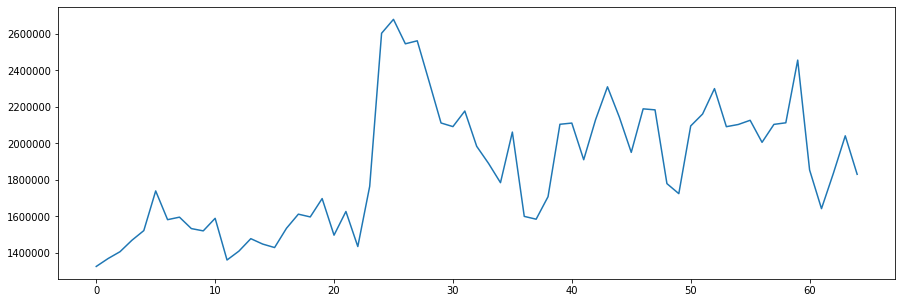

In [3]:
fig, axes = plt.subplots(figsize = (15, 5))
axes.plot(data['custo'])

In [4]:
data['log_custo'] = data['custo'].apply(lambda x: np.log(x))
data.head()

,Meses,custo,d_2004_01,log_custo
0,2002-01-01 00:00:00,1.325760e+06,0,14.097496
1,2002-02-01 00:00:00,1.369245e+06,0,14.129770
2,2002-03-01 00:00:00,1.406616e+06,0,14.156698
3,2002-04-01 00:00:00,1.469270e+06,0,14.200276
4,2002-05-01 00:00:00,1.522230e+06,0,14.235687


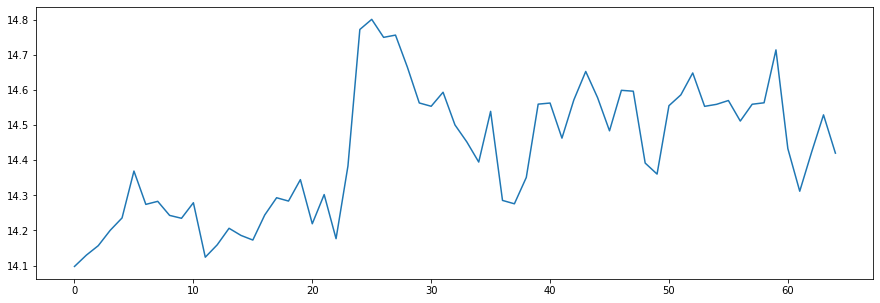

In [5]:
fig, axes = plt.subplots(figsize = (15, 5))
axes.plot(data['log_custo'])

In [6]:
reg = smf.ols('log_custo ~ 1 + d_2004_01', data = data)

In [7]:
est = reg.fit(cov_type = 'HAC', cov_kwds={'maxlags':1})
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              log_custo   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     105.0
Date:                Sat, 23 May 2020   Prob (F-statistic):           4.83e-15
Time:                        18:56:35   Log-Likelihood:                 50.980
No. Observations:                  65   AIC:                            -97.96
Df Residuals:                      63   BIC:                            -93.61
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.2333      0.017    827.399      0.0

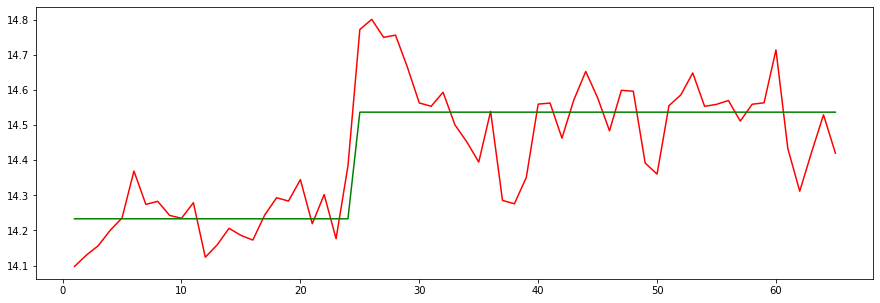

In [8]:
pred = est.predict(data['d_2004_01'])
tamanho = len(data['d_2004_01'])
x2 = range(1, tamanho+1)
fig, axes  =  plt.subplots(figsize = (15, 5))
axes.plot(x2, data['log_custo'], 'r', label = 'Valor Observado') 
axes.plot(x2, pred, 'g', label = 'Valor Observado') 

In [9]:
ACF, q, pq = ts.acf(data['log_custo'], qstat=True, fft = False, nlags = 20)
PACF = ts.pacf(data['log_custo'], nlags = 20)

In [10]:
tabela = np.c_[range(1,21), ACF[1:], PACF[1:], q, pq]
tabela = pd.DataFrame(tabela, columns=['lag', "ACF", "PACF", "Q", "Prob(>Q)"])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


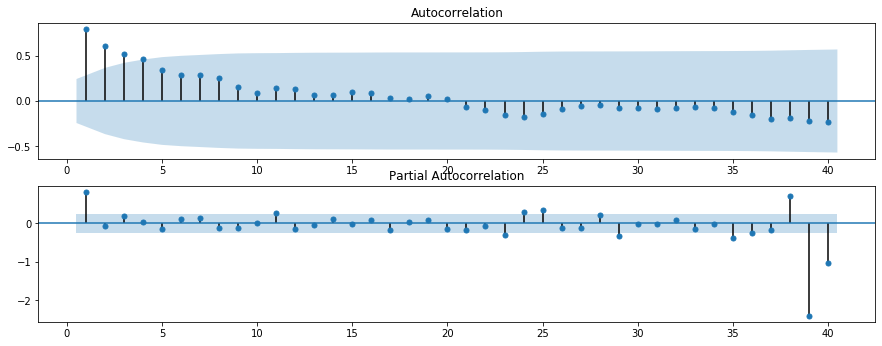

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,5.5))
fig = plot_acf(data['log_custo'], lags=40, zero=False, ax=ax1)

fig = plot_pacf(data['log_custo'], lags=40, zero=False, ax=ax2)

In [12]:
modelo = sm.tsa.ARMA(data['log_custo'], (1,0), exog = data['d_2004_01'])
modelo = modelo.fit(method = "css")

In [13]:
print(modelo.summary())

                              ARMA Model Results                              
Dep. Variable:              log_custo   No. Observations:                   65
Model:                     ARMA(1, 0)   Log Likelihood                  63.839
Method:                           css   S.D. of innovations              0.089
Date:                Sat, 23 May 2020   AIC                           -119.679
Time:                        18:56:36   BIC                           -111.043
Sample:                             1   HQIC                          -116.277
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              14.2353      0.043    329.370      0.000      14.151      14.320
d_2004_01           0.3046      0.051      5.939      0.000       0.204       0.405
ar.L1.log_custo     0.5828      

In [14]:
sm.stats.durbin_watson(modelo.resid.values)

1.9153967875113016

In [15]:
residuo = modelo.resid
residouquad = residuo**2
estimado = modelo.predict()
residuo = pd.DataFrame(residuo,  columns=['Residuos'])

In [16]:
dif = len(data) - len(estimado)
x1 = range(dif, len(data))
x2 = range(1, len(data)+1)

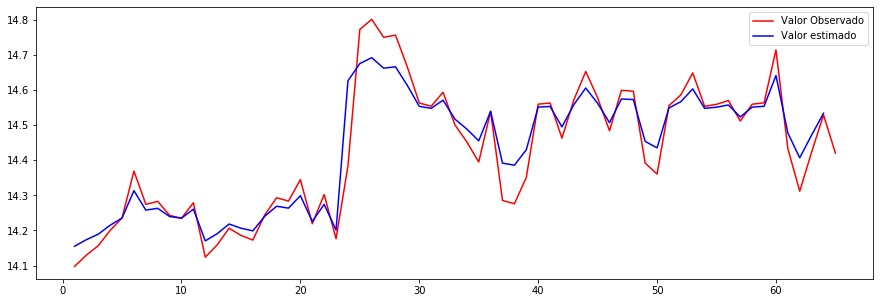

In [17]:
fig, axes  =  plt.subplots(figsize = (15, 5))

axes.plot(x2, data['log_custo'], 'r', label = 'Valor Observado') 
axes.plot(x1, estimado, 'b',  label = 'Valor estimado')
axes.legend()

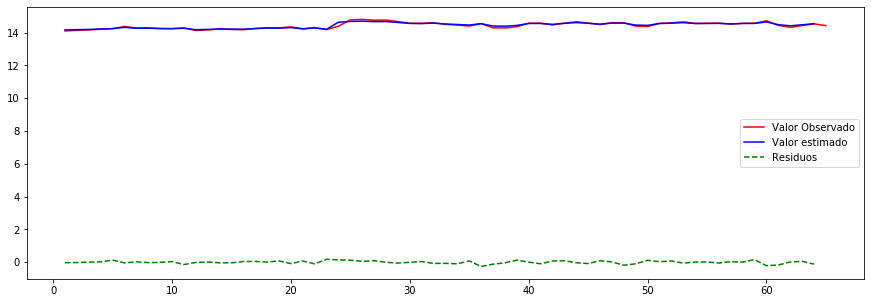

In [18]:
fig, axes  =  plt.subplots(figsize = (15, 5))

axes.plot(x2, data['log_custo'], 'r', label = 'Valor Observado') 
axes.plot(x1, estimado, 'b',  label = 'Valor estimado')

axes.plot(x1, residuo, 'g--', label = 'Residuos')
axes.legend()

In [19]:
ACF, q, pq = ts.acf(residuo, qstat=True, fft = False, nlags = 20)
PACF = ts.pacf(residuo, method = 'ols', nlags = 20)
tabela = np.c_[range(1,21), ACF[1:], PACF[1:], q, pq]
tabela = pd.DataFrame(tabela, columns=['lag', "ACF", "PACF", "Q", "Prob(Q>q)"])
tabela[0:20]

,lag,ACF,PACF,Q,Prob(Q>q)
0,1.0,0.029049,0.029723,0.056579,0.811986
1,2.0,-0.099004,-0.103765,0.724361,0.696157
2,3.0,-0.022869,-0.016293,0.760576,0.858872
3,4.0,0.280880,0.305847,6.314693,0.176847
4,5.0,-0.073865,-0.103755,6.705305,0.243496
5,6.0,-0.237717,-0.287575,10.820738,0.094077
6,7.0,0.077417,0.184159,11.264882,0.127475
7,8.0,0.124939,0.030678,12.442299,0.132534
8,9.0,-0.154174,-0.227441,14.267812,0.113112
9,10.0,-0.319583,-0.244491,22.256914,0.013848


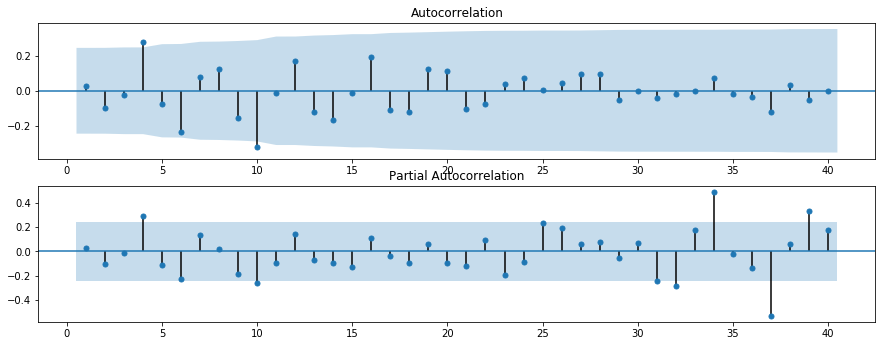

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,5.5))

fig = plot_acf(residuo, lags=40, zero=False, ax=ax1)
fig = plot_pacf(residuo, lags=40, zero=False, ax=ax2)

Adicionando o MA(4), mas para isso é necessário usar outro método. Este método se encaixa na classe de modelos de Espaço Estado.

In [21]:
ar = 1
ma = (0, 0, 0, 1)

modelo2 = sm.tsa.statespace.SARIMAX(data['log_custo'], order = (ar, 0, ma), trend = 'c', exog = data['d_2004_01']).fit()
print(modelo2.summary())

                               SARIMAX Results                                
Dep. Variable:              log_custo   No. Observations:                   65
Model:             SARIMAX(1, 0, [4])   Log Likelihood                  61.018
Date:                Sat, 23 May 2020   AIC                           -112.036
Time:                        18:56:38   BIC                           -101.164
Sample:                             0   HQIC                          -107.747
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4116      0.688      0.599      0.549      -0.936       1.759
d_2004_01      0.4740      0.214      2.213      0.027       0.054       0.894
ar.L1          0.9707      0.049     19.908      0.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


sigma2 é a variância do erro.

In [22]:
sm.stats.durbin_watson(modelo2.resid.values)

2.3407504955103358

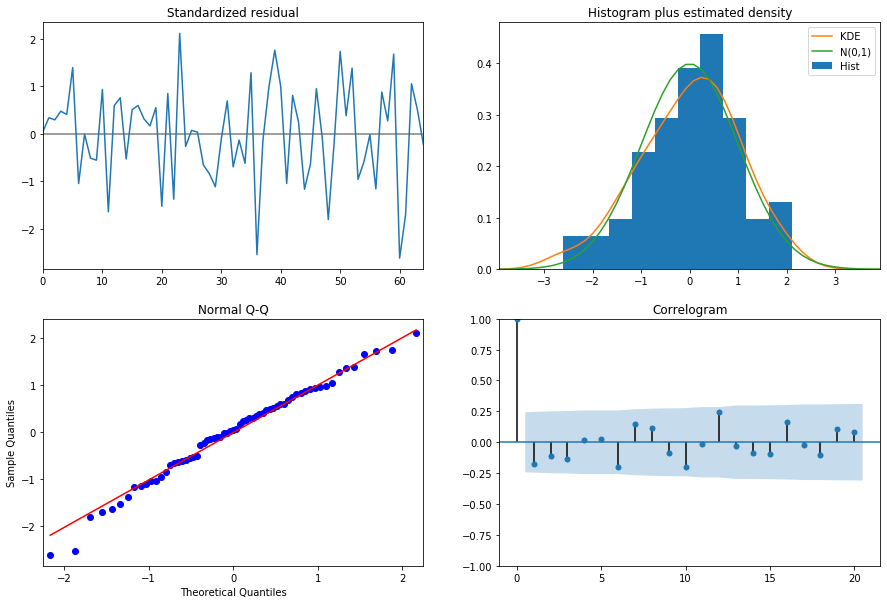

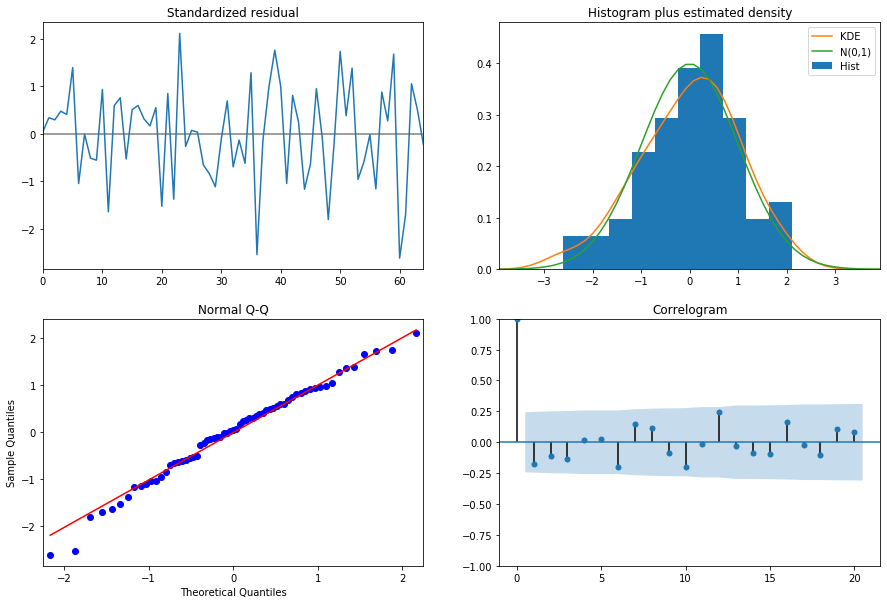

In [23]:
modelo2.plot_diagnostics(figsize = (15,10), lags = 20)

In [35]:
modelo2.forecast(exog = data['d_2004_01'])

ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 1), got (65,).